In [1]:
import pandas as pd
import numpy as np
import codecs
from unidecode import unidecode
import re
import sys
import csv
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('../inputs/train_clean.tsv', sep = '\t', encoding = 'utf-8', engine = "python")
print (len(df))

1482535


In [23]:
df.head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Decor/Home Decor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [25]:
# remove the rows where price is zero
df = df.loc[df['price'] > 0, :]
print (len(df))
print (df.dtypes)
print ('\nunique values\n')
for col in df.columns:
    print (col, len(df[col].unique()))
print ('\nnans\n')
for col in df.columns:
    print (col, df[col].isnull().sum())

1481661
train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

unique values

train_id 1481661
name 1222951
item_condition_id 5
category_name 1288
brand_name 4803
price 827
shipping 2
item_description 1280441

nans

train_id 0
name 11
item_condition_id 0
category_name 6314
brand_name 632336
price 0
shipping 0
item_description 43


In [26]:
# checking what the rows without any name look like
print (df.loc[df['name'].isnull(), :])

         train_id name  item_condition_id  \
208439     208439  NaN                  1   
309630     309630  NaN                  2   
389500     389500  NaN                  2   
421954     421954  NaN                  1   
695281     695281  NaN                  2   
1012745   1012745  NaN                  2   
1271199   1271199  NaN                  3   
1322409   1322409  NaN                  3   
1360970   1360970  NaN                  2   
1427407   1427407  NaN                  2   
1471652   1471652  NaN                  3   

                                      category_name       brand_name  price  \
208439                 Handmade/Accessories/Lanyard              NaN   24.0   
309630                            Women/Skirts/Mini  Brandy Melville   26.0   
389500                Women/Tops & Blouses/T-Shirts             PINK   16.0   
421954                       Women/Jewelry/Earrings              NaN    8.0   
695281       Women/Tops & Blouses/Button Down Shirt             

In [27]:
# checking what the rows without any item_description look like
print (df.loc[df['item_description'].isnull(), :])

         train_id                                      name  \
3552         3552                    Strappy Black Lingerie   
119970     119970                  Bundle for Hopeismyangel   
142890     142890                           Bow Tie Chocker   
219766     219766             Crochet Halter Cream Crop Top   
222500     222500                       Criss Cross Pasties   
227220     227220                  Bundle for PandoraLover    
275138     275138       Skirt and bodysuit bundle for kasey   
293625     293625              FOUR 100% Activated Charcoal   
299025     299025  Olive Green Halter Top With Back Keyhole   
320041     320041                           Bundle For Ruby   
323341     323341                      White Strappy Crop T   
344824     344824                                 for buyer   
366077     366077                       Surplice White Tank   
371294     371294                      Pink Halter Crop Top   
485587     485587                    Rainbow Floral Pas

In [3]:
# most of the item's without name/item description also have brand name empty..
# and also form a minor fraction of the dataset.. hence remove them
df = df.loc[~((df['name'].isnull()) | (df['item_description'].isnull()) | (df['category_name'].isnull())), :]
print (len(df))

1476154


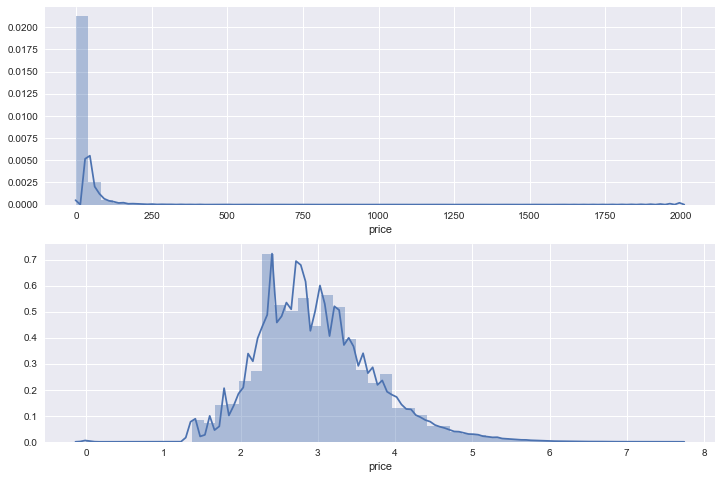

In [8]:
# overall price distribution
fig, axs = plt.subplots(nrows=2, figsize=(12,8))
sns.distplot(df['price'], ax = axs[0])
sns.distplot(np.log(df['price'] + 1), ax = axs[1])

In [4]:
# category names
df['num_categories'] = df['category_name'].apply(lambda x: len(str(x).split('/')))

In [5]:
df2 = df['category_name'].str.split('/', n=2, expand=True)
df2.columns = ['cat1', 'cat2', 'cat3']
print (len(df2))
# print (df2.columns)
print (df2.head(5))

1476154
          cat1                 cat2                cat3
0          Men                 Tops            T-shirts
1  Electronics  Computers & Tablets  Components & Parts
2        Women       Tops & Blouses              Blouse
3         Home           Home Decor  Home Decor Accents
4        Women              Jewelry           Necklaces


In [6]:
for i in range(1,4):
    df['cat' + str(i)] = df2['cat' + str(i)]
del df2

In [10]:
# print (df.head(5))
for i in range(1,4):
    print (len(df['cat' + str(i)].unique()))

10
112
871


In [48]:
# add the log price variable
df['log_price'] = df['price'].apply(lambda x: np.log(x + 1))
# add the char length of description
df['char_count_unclean'] = df['item_description'].apply(lambda x: len(x))
# add the char count of special characters
regex_special_char = re.compile(r'[~\`!\@#\$%\^&\(\)\\\|\?\/\<\>\;\:\'\"]')
df['char_count_special'] = df['item_description'].apply(
    lambda x: len(regex_special_char.findall(x)) if regex_special_char.findall(x) is not None else 0)
# add the count of asteriks
regex_asterik = re.compile(r'\*')
df['char_count_asterik'] = df['item_description'].apply(
    lambda x: len(regex_asterik.findall(x)) if regex_asterik.findall(x) is not None else 0)

In [18]:
print (df['cat1'].unique().tolist())

['Men', 'Electronics', 'Women', 'Home', 'Sports & Outdoors', 'Vintage & Collectibles', 'Beauty', 'Other', 'Kids', 'Handmade']


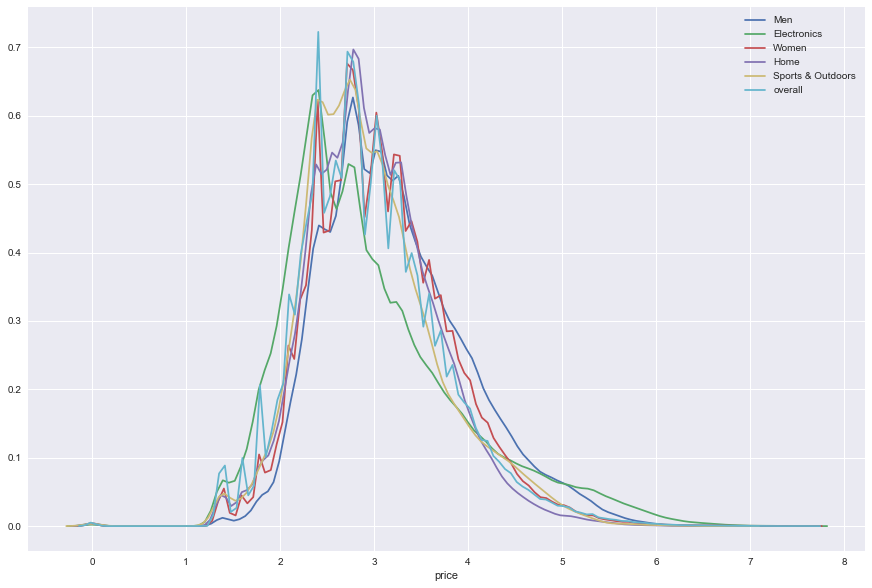

In [46]:
cat1_unique = df['cat1'].unique().tolist()
fig, axs = plt.subplots(nrows=1, figsize=(15, 10))
for i in range(5):
    filter1 = df['cat1'] == cat1_unique[i]
    # sns.distplot(df.loc[filter1, 'price'], ax = axs[i]).set_title(cat1_unique[i//2])
    sns.distplot(np.log(df.loc[filter1, 'price'] + 1), label=cat1_unique[i], hist=False)
sns.distplot(np.log(df['price'] + 1), label='overall', hist=False)
plt.legend()

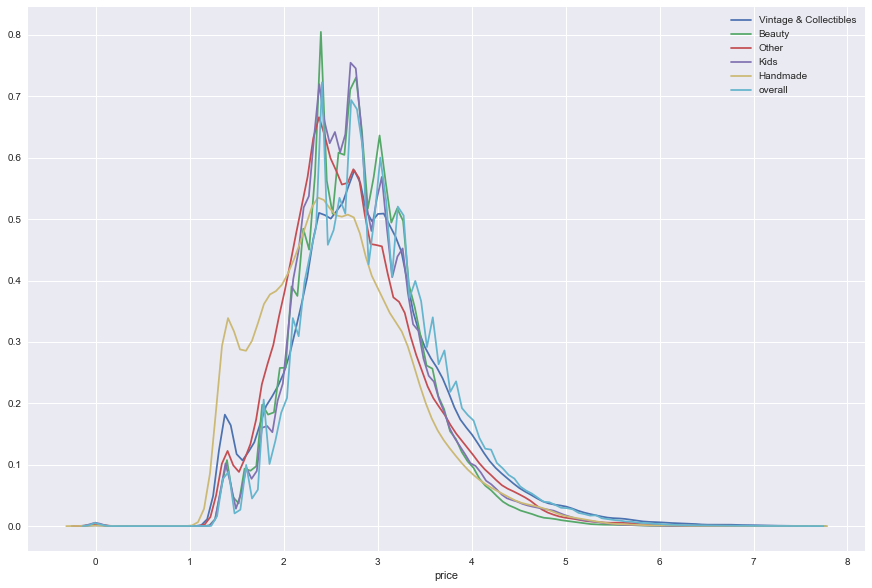

In [47]:
fig, axs = plt.subplots(nrows=1, figsize=(15, 10))
for i in range(5, len(cat1_unique)):
    filter1 = df['cat1'] == cat1_unique[i]
    # sns.distplot(df.loc[filter1, 'price'], ax = axs[i]).set_title(cat1_unique[i//2])
    sns.distplot(np.log(df.loc[filter1, 'price'] + 1), label=cat1_unique[i], hist=False)
sns.distplot(np.log(df['price'] + 1), label='overall', hist=False)
plt.legend()

Price Distribution for Handmade and Electronics looks different looks very different from the overall price distribution.
Let's verify with a box plot

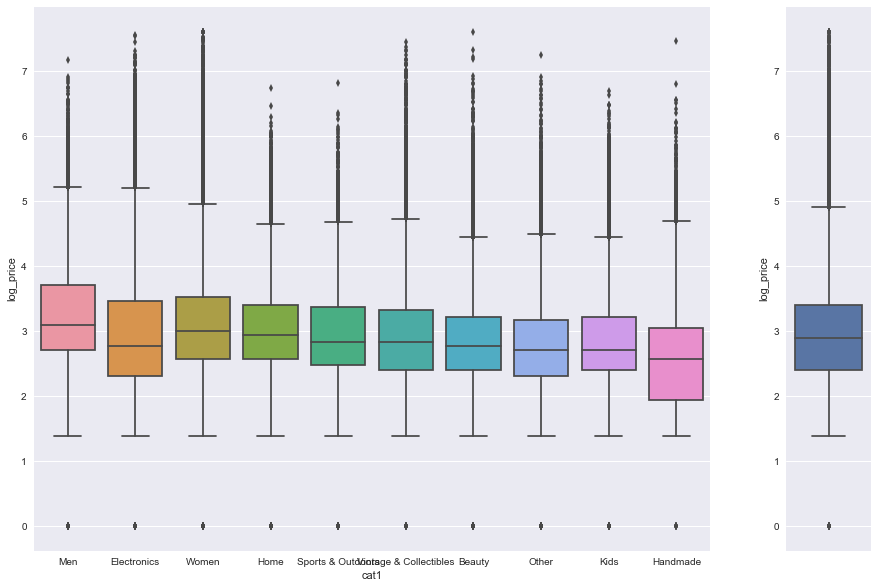

In [12]:
fig, axs = plt.subplots(ncols = 2, figsize=(15, 10), gridspec_kw = {'width_ratios':[8, 1]})
sns.boxplot(x = 'cat1', y = 'log_price', data = df, ax = axs[0])
sns.boxplot(y = 'log_price', data = df, ax = axs[1])

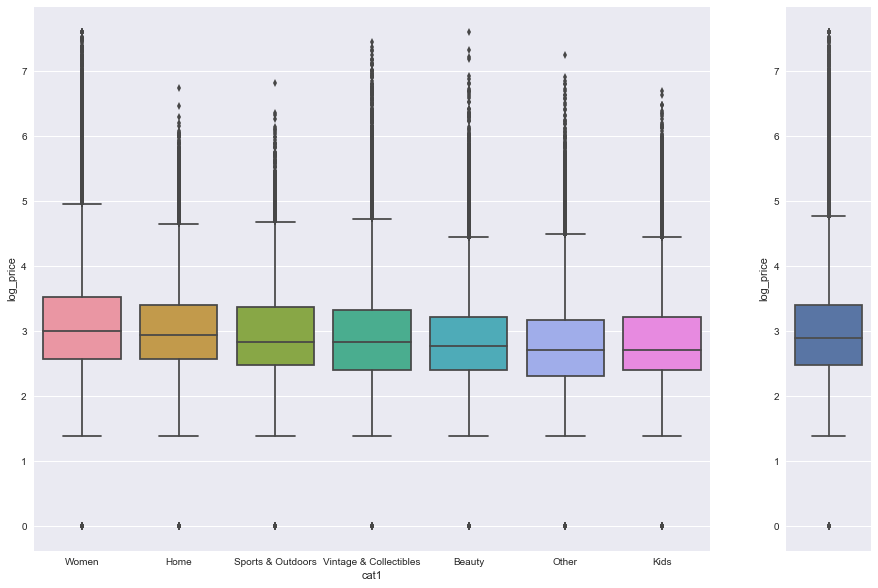

In [17]:
filter2 = (df['cat1'] != 'Men') & (df['cat1'] != 'Electronics') & (df['cat1'] != 'Handmade')
fig, axs = plt.subplots(ncols = 2, figsize=(15, 10), gridspec_kw = {'width_ratios':[8, 1]})
sns.boxplot(x = 'cat1', y = 'log_price', data = df.loc[filter2, :], ax = axs[0])
sns.boxplot(y = 'log_price', data = df.loc[filter2, :], ax = axs[1])

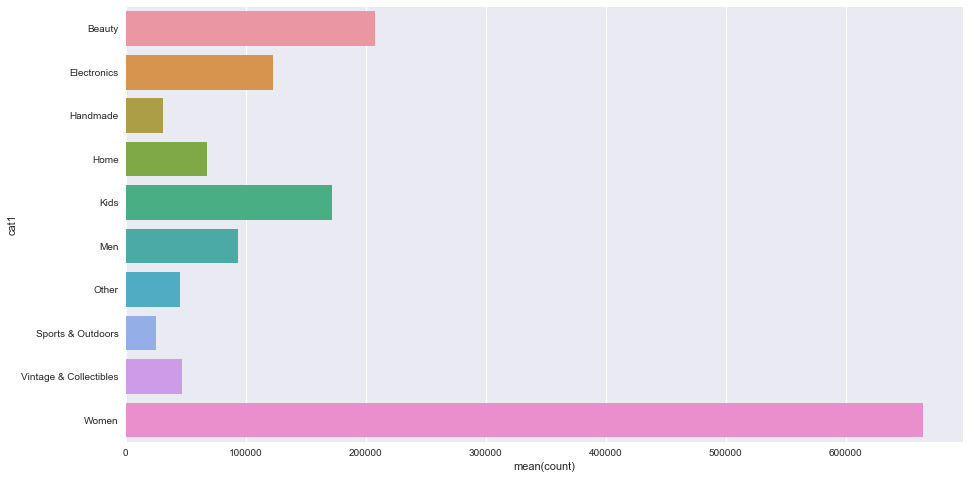

In [26]:
df_cat1 = df.groupby(['cat1']).count()['price'].reset_index().rename(columns = {'price':'count'})
fig, axs = plt.subplots(ncols = 1, figsize=(15, 8))
sns.barplot(y = 'cat1', x = 'count', data = df_cat1)

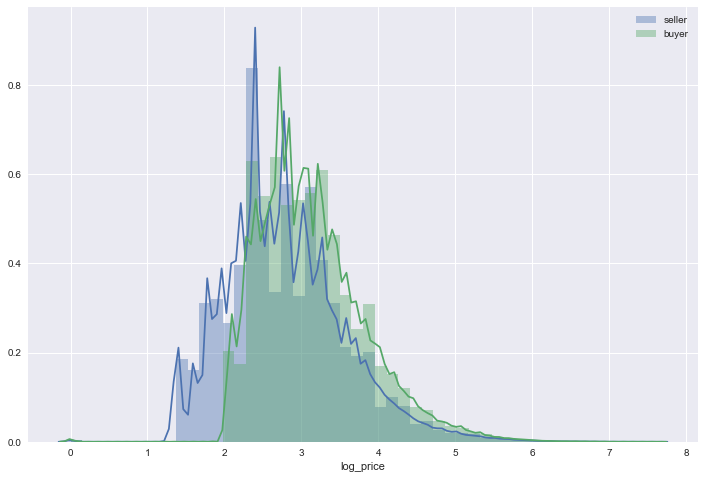

In [29]:
# overall price distribution
fig, axs = plt.subplots(nrows=1, figsize=(12,8))
sns.distplot(df.loc[df['shipping']==1,'log_price'], label = 'seller')
sns.distplot(df.loc[df['shipping']==0,'log_price'], label = 'buyer')
plt.legend()

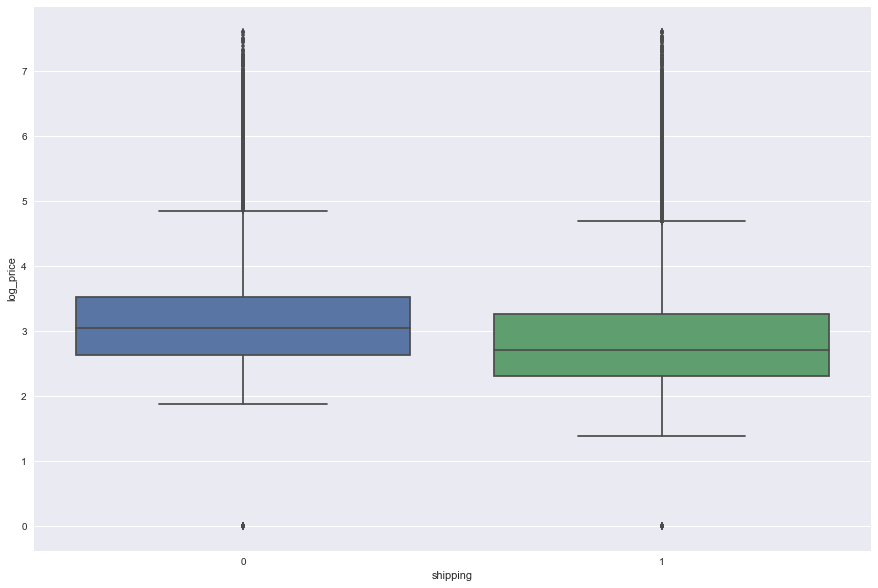

In [30]:
fig, axs = plt.subplots(ncols = 1, figsize=(15, 10))
sns.boxplot(x = 'shipping', y = 'log_price', data = df)

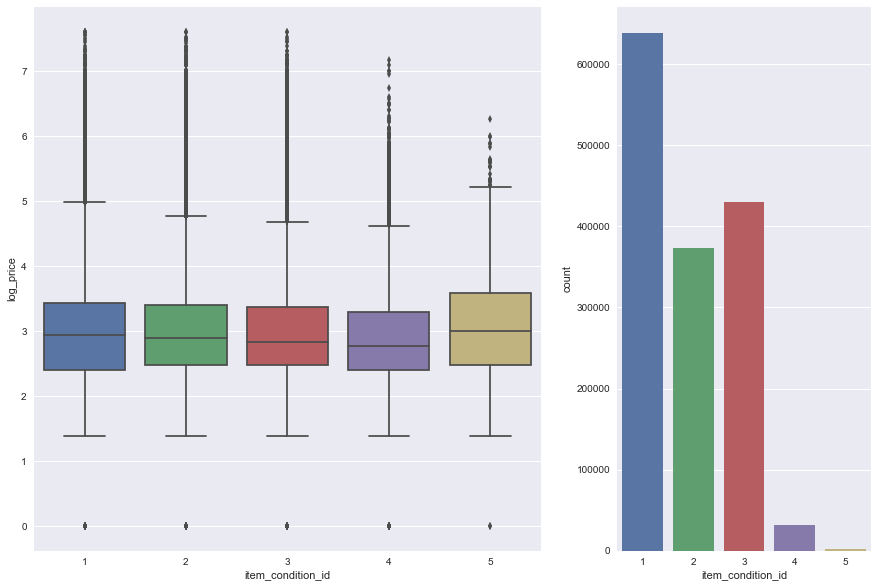

In [36]:
fig, axs = plt.subplots(ncols = 2, figsize=(15, 10), gridspec_kw = {'width_ratios':[2, 1]})
sns.boxplot(x = 'item_condition_id', y = 'log_price', data = df, ax = axs[0])
sns.countplot(x = 'item_condition_id', data = df, ax = axs[1])

In [46]:
# top brands byb total sales
top_brands = df.groupby(['brand_name']).sum()['price'].reset_index().sort_values(by='price', ascending=False).head(30)
top_brands['rank'] = top_brands['price']

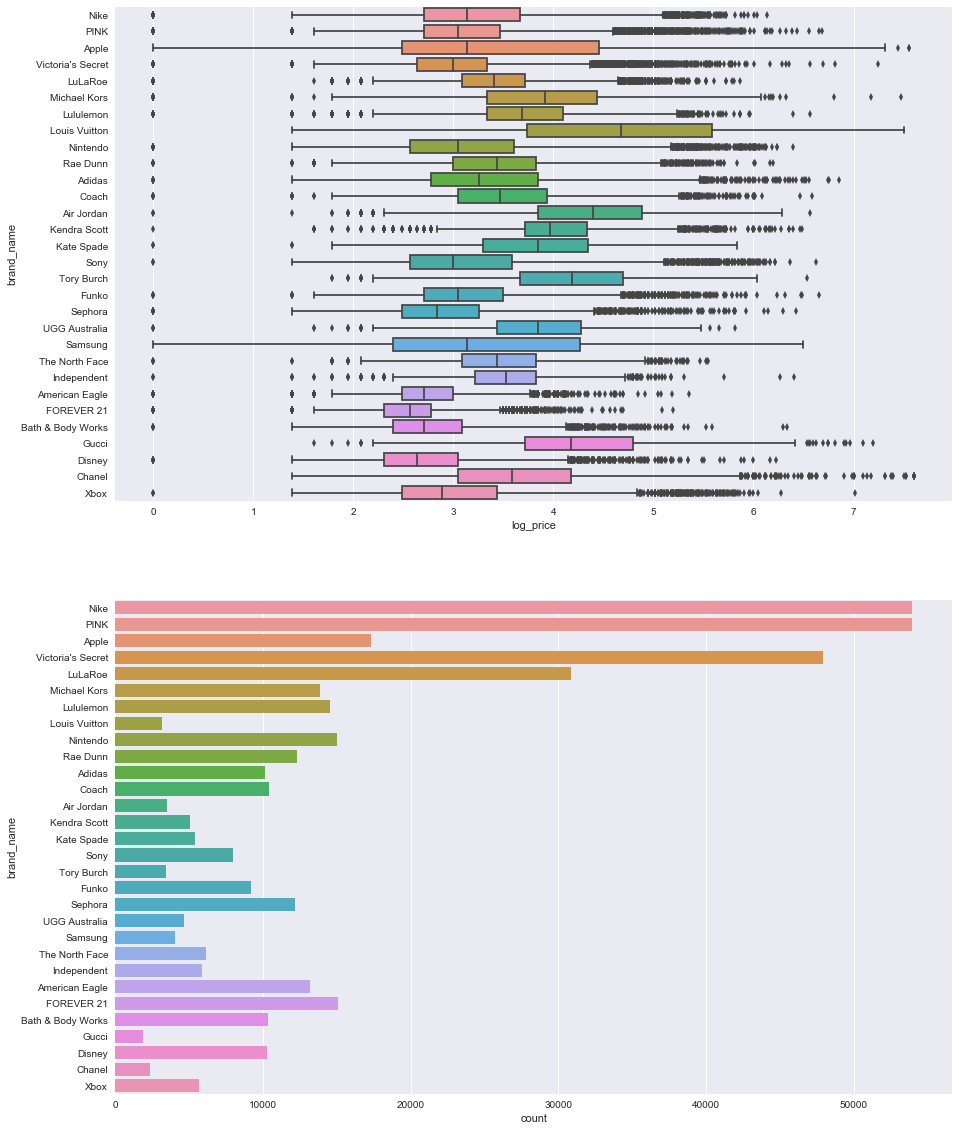

In [47]:
# filter_top_brands = df['brand_name'].isin(top_brands['brand_name'].values.tolist())
df_top_brands = pd.merge(left=df[['brand_name', 'log_price']], right=top_brands[['brand_name', 'rank']],
                         how = 'inner', on = 'brand_name').sort_values(by='rank', ascending=False)
fig, axs = plt.subplots(nrows = 2, figsize=(15, 20), gridspec_kw = {'height_ratios':[1, 1]})
sns.boxplot(x = 'log_price', y = 'brand_name', data = df_top_brands, ax = axs[0])
sns.countplot(y = 'brand_name', data = df_top_brands, ax = axs[1])

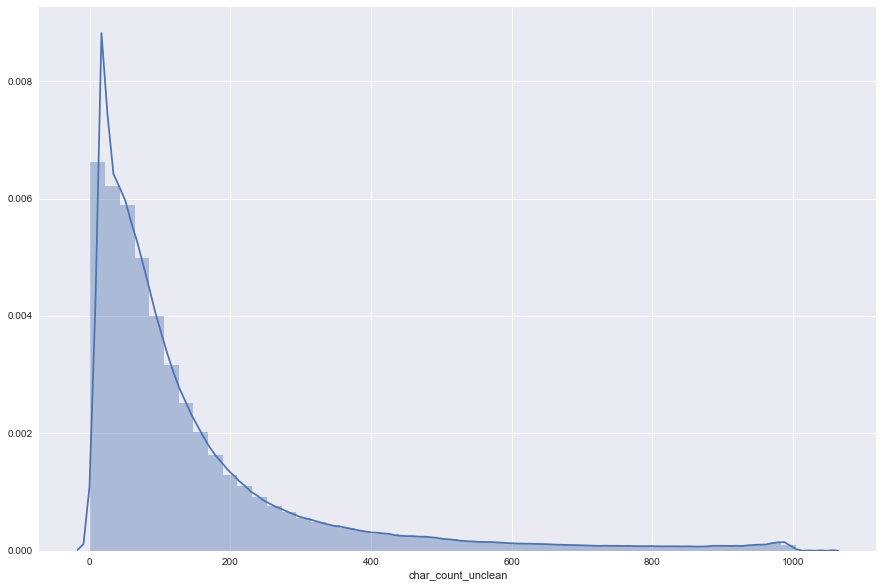

In [54]:
# correlations between price and char lengths
fig, axs = plt.subplots(nrows = 1, figsize=(15, 10))
sns.distplot(df['char_count_unclean'])

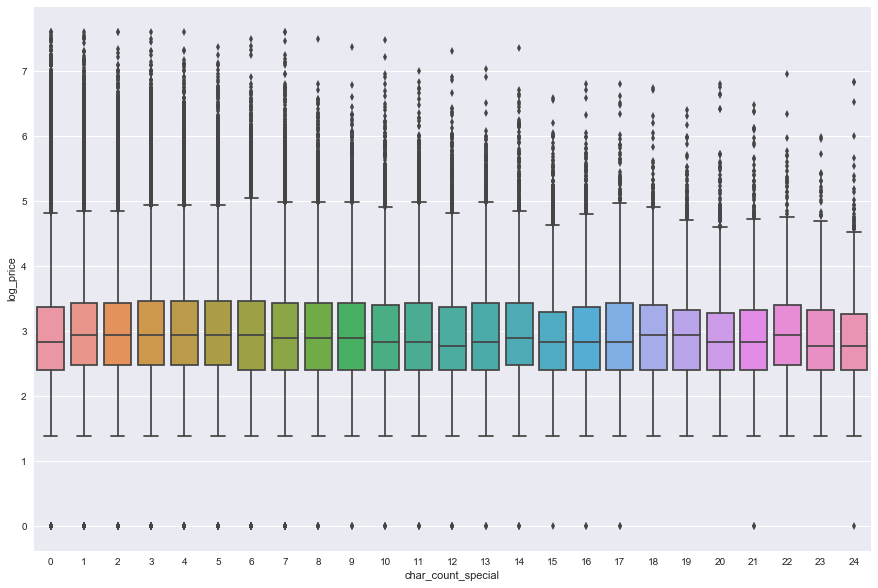

In [63]:
fig, axs = plt.subplots(nrows = 1, figsize=(15, 10))
sns.boxplot(x = 'char_count_special', y = 'log_price', data = df.loc[df['char_count_special'] < 25,:])

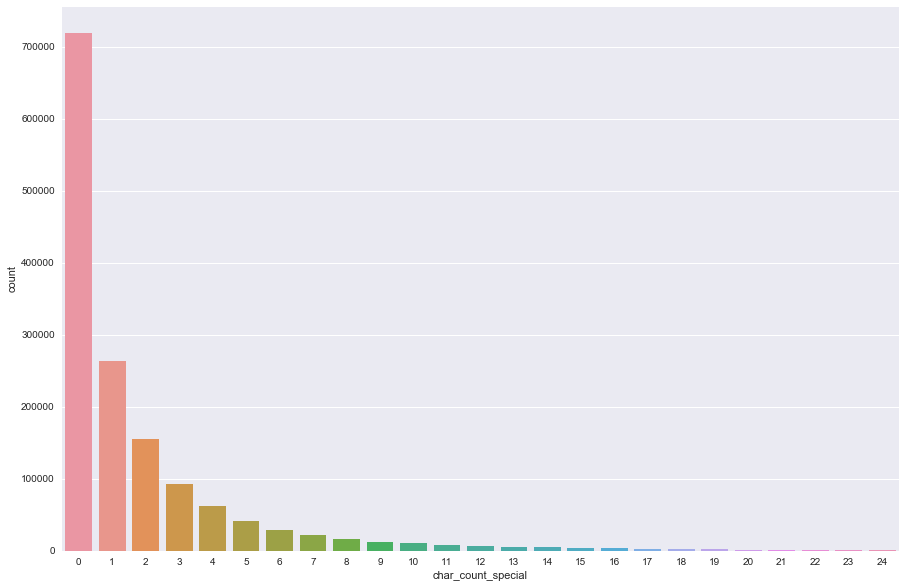

In [64]:
fig, axs = plt.subplots(nrows = 1, figsize=(15, 10))
sns.countplot(x = 'char_count_special', data = df.loc[df['char_count_special'] < 25,:])